# Steerability Evaluation

## Friday 2024-10-18

### Skeleton

Overview:

We want to build an eval that tests Honcho-like steerable systems. For our purposes, a Honcho-like steerable system is capable of a) taking some observations about a user and b) based on those observations, infer how that user would think and behave. Ultimately, this eval framework will help us make evidence-based decisions when building newer versions of Honcho.

- **Eval step 1: steering**. To measure how good a particular steerable system is, we first steer it towards a certain persona. We do this by giving it a certain set of observations about the persona, e.g. what they did or thought in certain scenarios.
	- Once they receive the user observations, different steerable systems will implement this steering differently. For example, a baseline system could simply inject the observations into a few-shot prompt; our first implementation of Honcho uses the observations to write up a natural language user representation; further versions could use them to train a LoRRA...
	- In order to be fair, our eval should be agnostic to the way steerable systems implement steering. After all, what we want to measure is how well a certain system can adapt its behavior to model a user based on certain observations—whether it does it using a prompt, LoRRA or a pool of 500 human experts that can type at the speed of sound shouldn't affect its score. 
- **Eval step 2: testing**. After steering a system towards a certain persona, we test whether it can accurately infer the persona's thoughts or behaviors, i.e. how accurately it can predict a held-out part of the scenario-action dataset for that persona.
- **Eval step 3: aggregation**. We repeat steps 1 and 2 over a large number of personas (e.g. N=100). We have every steered persona x take a test to measure how well it models every persona y. Ideally, if we plot a heat map of the accuracy of the model steered to persona x when tested on persona y, we'd see a strong diagonal, i.e. the model steered to a certain persona scores high on that persona's test, and low on all others. 
	- We could also look at specific horizontal or vertical slices of this plot. For example, a horizontal slice tells us, for a given persona test, how well all steered systems model it. A vertical slice tells us, for a given steered model, how well it does on each persona test.
- **Step 4: system score**. The entire steerable system is given a score based on this heat map. There's a few ways we could do this: 
	- How often is a test "won" by its corresponding steered model? I.e. on average, for a given test persona, how often is the highest score achieved by the model that was steered to that same persona? (is this somewhat akin to specificity?)
	- How often does a steered model do best at its own score? I.e. on average, for a system steered to a given persona, how often is its highest score achieved on the test for the same persona? (is this somewhat akin to sensitivity?)
	- Combining both measures into a sort of F1-score.

In [8]:
from typing import List, Dict, Set, Tuple

import pandas as pd

SystemResponse = str
PersonaId = str
ScenarioId = str
ObservationId = str
MAX_PERSONAS = 20
MAX_OBSERVATIONS_PER_PERSONA = 10

import hashlib

def generate_short_hash(text: str) -> str:
    return hashlib.md5(text.encode()).hexdigest()[:8]

class Persona:
    def __init__(self, persona_id: PersonaId, persona_description: str, persona_framework: str):
        self.persona_id = persona_id
        self.persona_description = persona_description
        self.persona_framework = persona_framework

    def __repr__(self):
        return f'Persona(persona_id={self.persona_id}, persona_description={self.persona_description}, persona_framework={self.persona_framework})'


class Observation:
    def __init__(
        self,
        observation_id: ObservationId,
        response: str,
        scenario_id: ScenarioId,
        scenario_description: str,
        persona_id: PersonaId,
    ):
        self.observation_id = observation_id
        self.response = response
        self.scenario_id = scenario_id
        self.scenario_description = scenario_description
        self.persona_id = persona_id
    def __repr__(self):
        return f'Observation(observation_id={self.observation_id}, persona_id={self.persona_id}, scenario_description={self.scenario_description[:30]}, response={self.response[:30]})'

class Dataset:
    def __init__(
        self,
        personas: Dict[PersonaId, Persona],
        observations: List[Observation],
        max_personas: int = MAX_PERSONAS,
        max_observations_per_persona: int = MAX_OBSERVATIONS_PER_PERSONA,
        response_types: List[str] = ['action'],
    ):
        self.max_personas = max_personas
        self.max_observations_per_persona = max_observations_per_persona
        self.response_types = response_types
        self.personas = personas
        self.observations = observations

    @classmethod
    def from_csv(cls,
                 personas_path: str,
                 observations_path: str,
                 max_personas: int = MAX_PERSONAS,
                 max_observations_per_persona: int = MAX_OBSERVATIONS_PER_PERSONA,
                 use_actions: bool = True,
                 use_thoughts: bool = False,
                 use_emotions: bool = False):
        personas = cls.load_personas(personas_path, max_personas)
        persona_ids = list(personas.keys())
        response_types = []
        if use_actions:
            response_types.append('action')
        if use_thoughts:
            response_types.append('thought')
        if use_emotions:
            response_types.append('emotion')
        observations = cls.load_observations(observations_path, response_types, persona_ids)
        return cls(personas,
                   observations,
                   max_personas,
                   max_observations_per_persona,
                   response_types)

    @classmethod
    def load_personas(cls, personas_path: str, max_personas: int = MAX_PERSONAS) -> Dict[PersonaId, Persona]:
        with open(personas_path, 'r') as f:
            df = pd.read_csv(f)
        df = df.head(max_personas)
        personas = {}
        for index, row in df.iterrows():
            persona = Persona(row['persona_id'], row['persona_description'], row['framework_name'])
            personas[persona.persona_id] = persona
        return personas

    @classmethod
    def load_observations(cls,
                          observations_path: str,
                          response_types: List[str],
                          persona_ids: List[PersonaId]) -> List[Observation]:
        with open(observations_path, 'r') as f:
            df = pd.read_csv(f)
        observations = []
        for index, row in df.iterrows():
            if row['persona_id'] not in persona_ids:
                continue
            scenario = f'{row["context"]}\n{row["scenario"]}'
            scenario_id = row['scenario_id']
            for response_type in response_types:
                response = row[response_type]
                observation_id = generate_short_hash(f'{response}{scenario_id}')
                observation = Observation(observation_id, response, scenario_id, scenario, row['persona_id'])
                observations.append(observation)
        return observations

    @property
    def persona_ids(self) -> Set[PersonaId]:
        return set(self.personas.keys())

    def get_observations(self, persona: Persona) -> List[Observation]:
        return [observation for observation in self.observations if observation.persona_id == persona.persona_id]

    def split(self, n_steer_observations_per_persona: int = 5) -> Tuple['Dataset', 'Dataset']:
        steer_observations = []
        test_observations = []
        for persona in self.personas.values():
            observations = self.get_observations(persona)
            steer_observations.extend(observations[:n_steer_observations_per_persona])
            test_observations.extend(observations[n_steer_observations_per_persona:])
        return Dataset(self.personas, steer_observations), Dataset(self.personas, test_observations)


    


In [9]:
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'

dataset = Dataset.from_csv(personas_path, observations_path)


In [3]:
steer_dataset, test_dataset = dataset.split()

In [4]:
# Is any observation in the test dataset also in the steer dataset?
test_observation_ids = [observation.observation_id for observation in test_dataset.observations]
steer_observation_ids = [observation.observation_id for observation in steer_dataset.observations]
for test_observation_id in test_observation_ids:
    if test_observation_id in steer_observation_ids:
        print(test_observation_id)



In [12]:
import random


class BaseSteerableSystem:
    def __init__(self):
        pass

    def steer(self, persona: Persona, steer_observations: List[Observation]) -> 'BaseSteeredSystem':
        raise NotImplementedError


class BaseSteeredSystem:
    def __init__(self, persona: Persona, steerable_system: BaseSteerableSystem, steer_observations: List[Observation]):
        self.persona = persona
        self.steerable_system = steerable_system
        self.steer_observations = steer_observations

    def run_inference(self, scenario) -> SystemResponse:
        raise NotImplementedError

        
class DummySteerableSystem(BaseSteerableSystem):
    def __init__(self):
        pass

    def steer(self, persona: Persona, steer_observations: List[Observation]) -> BaseSteeredSystem:
        print(f'Steering to persona {persona.persona_id}')
        return DummySteeredSystem(persona, self, steer_observations)
    

class DummySteeredSystem(BaseSteeredSystem):
    def __init__(self, persona: Persona, steerable_system: BaseSteerableSystem, steer_observations: List[Observation]):
        super().__init__(persona, steerable_system, steer_observations)

    def run_inference(self, scenario) -> SystemResponse:
        # Random Y/N
        return 'Y' if random.random() < 0.5 else 'N'

    def __repr__(self):
        return f'DummySteeredSystem(persona={self.persona.persona_id}, steerable_system={self.steerable_system})'

class SteerabilityEval:
    def __init__(self, tested_system: BaseSteerableSystem, dataset: Dataset):
        self.tested_system = tested_system
        self.dataset = dataset
        self.personas = self.dataset.personas
        self.steer_set, self.test_set = self.dataset.split()
        self.max_observations = 100

    def steer_to_persona(self, persona: Persona) -> BaseSteeredSystem:
        steer_observations = self.steer_set.get_observations(persona)
        steered_system = self.tested_system.steer(persona, steer_observations)
        return steered_system

    def test_steered_system_on_persona(self, steered_system: BaseSteeredSystem, test_persona: Persona) -> float:
        test_observations = self.test_set.get_observations(test_persona)
        correct_responses = 0
        for i, test_observation in enumerate(test_observations[:self.max_observations]):
            scenario = test_observation.scenario_description
            prompt = self.generate_prompt(test_observation)
            response = steered_system.run_inference(prompt)
            if response == 'Y':
                correct_responses += 1
        return correct_responses / (i + 1)

    def generate_prompt(self, test_observation: Observation) -> str:
        prompt = f'''
        {test_observation.scenario_description}.
        Is the following statement something you would say?
        {test_observation.response}
        '''
        return prompt

    def run_eval(self):
        # Steer systems
        self.steered_systems = {}
        for persona in self.dataset.personas.values():
            steered_system = self.steer_to_persona(persona)
            self.steered_systems[persona.persona_id] = steered_system

        # Test every system on every persona
        self.steered_system_scores = {}
        for steered_system in self.steered_systems.values():
            self.steered_system_scores[steered_system.persona.persona_id] = {}
            for test_persona in self.dataset.personas.values():
                score = self.test_steered_system_on_persona(steered_system, test_persona)
                self.steered_system_scores[steered_system.persona.persona_id][test_persona.persona_id] = score




In [13]:
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = Dataset.from_csv(personas_path, observations_path)

steerable_system = DummySteerableSystem()

In [14]:
eval = SteerabilityEval(steerable_system, dataset)
eval.run_eval()

Steering to persona 0447288b
Steering to persona 59465b9c
Steering to persona d31cd178
Steering to persona 0d713d4b
Steering to persona 35eb8c37
Steering to persona 04027dd6
Steering to persona 69af655f
Steering to persona 8881fc6a
Steering to persona 70099880
Steering to persona 27ae72cf
Steering to persona 8b640791
Steering to persona 960b9e70
Steering to persona a3044540
Steering to persona 1ee61741
Steering to persona cc0ef006
Steering to persona 2d57d05a
Steering to persona a05f9ce4
Steering to persona 08e3a4de
Steering to persona 688ad2c6


In [15]:
eval.steered_system_scores

{'0447288b': {'0447288b': 0.48,
  '59465b9c': 0.45,
  'd31cd178': 0.47,
  '0d713d4b': 0.44,
  '35eb8c37': 0.47,
  '04027dd6': 0.5,
  '69af655f': 0.49,
  '8881fc6a': 0.49,
  '70099880': 0.45,
  '27ae72cf': 0.59,
  '8b640791': 0.48,
  '960b9e70': 0.44,
  'a3044540': 0.45,
  '1ee61741': 0.48,
  'cc0ef006': 0.43,
  '2d57d05a': 0.53,
  'a05f9ce4': 0.51,
  '08e3a4de': 0.55,
  '688ad2c6': 0.47},
 '59465b9c': {'0447288b': 0.51,
  '59465b9c': 0.54,
  'd31cd178': 0.53,
  '0d713d4b': 0.48,
  '35eb8c37': 0.59,
  '04027dd6': 0.48,
  '69af655f': 0.55,
  '8881fc6a': 0.47,
  '70099880': 0.52,
  '27ae72cf': 0.54,
  '8b640791': 0.48,
  '960b9e70': 0.53,
  'a3044540': 0.5,
  '1ee61741': 0.47,
  'cc0ef006': 0.57,
  '2d57d05a': 0.47,
  'a05f9ce4': 0.52,
  '08e3a4de': 0.4,
  '688ad2c6': 0.46},
 'd31cd178': {'0447288b': 0.46,
  '59465b9c': 0.5,
  'd31cd178': 0.53,
  '0d713d4b': 0.5,
  '35eb8c37': 0.57,
  '04027dd6': 0.38,
  '69af655f': 0.47,
  '8881fc6a': 0.44,
  '70099880': 0.59,
  '27ae72cf': 0.6,
  '8b640

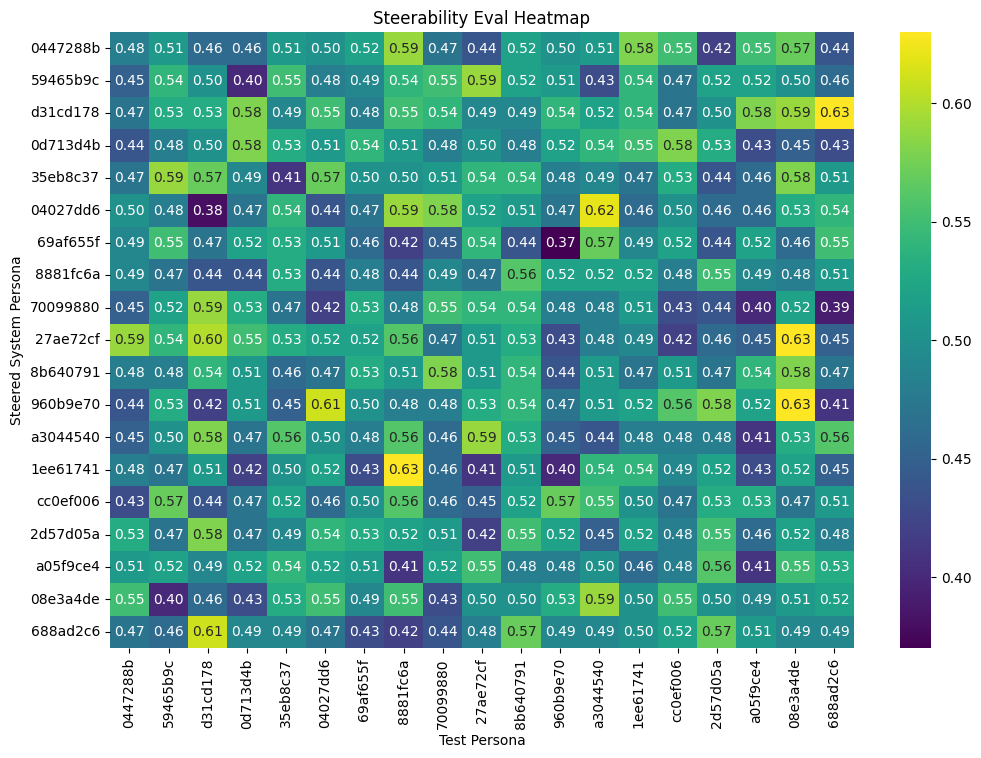

In [19]:
# plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Convert steered_system_scores to a DataFrame for easier plotting
scores_df = pd.DataFrame(eval.steered_system_scores)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scores_df, annot=True, fmt='.2f', cmap='viridis', cbar=True)
plt.title('Steerability Eval Heatmap')
plt.xlabel('Test Persona')
plt.ylabel('Steered System Persona')
plt.show()



# Monday 2024-10-21

## Move to package

Steering to persona 0447288b
Steering to persona 59465b9c
Steering to persona d31cd178
Steering to persona 0d713d4b
Steering to persona 35eb8c37
Steering to persona 04027dd6
Steering to persona 69af655f
Steering to persona 8881fc6a
Steering to persona 70099880
Steering to persona 27ae72cf
Steering to persona 8b640791
Steering to persona 960b9e70
Steering to persona a3044540
Steering to persona 1ee61741
Steering to persona cc0ef006
Steering to persona 2d57d05a
Steering to persona a05f9ce4
Steering to persona 08e3a4de
Steering to persona 688ad2c6


<Axes: title={'center': 'Steerability Eval Heatmap'}, xlabel='Test Persona', ylabel='Steered System Persona'>

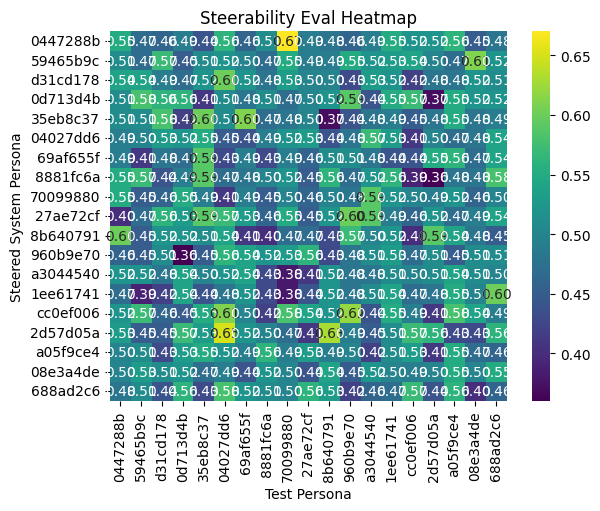

In [22]:
from steerability_eval.eval import SteerabilityEval
from steerability_eval.steerable.dummy import DummySteerableSystem
from steerability_eval.dataset.w5 import W5Dataset

personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path)

steerable_system = DummySteerableSystem()
eval = SteerabilityEval(steerable_system, dataset)
eval.run_eval()
eval.heatmap_fig


In [21]:
eval.steered_system_scores


{'0447288b': {'0447288b': 0.52,
  '59465b9c': 0.46,
  'd31cd178': 0.58,
  '0d713d4b': 0.56,
  '35eb8c37': 0.48,
  '04027dd6': 0.51,
  '69af655f': 0.53,
  '8881fc6a': 0.51,
  '70099880': 0.54,
  '27ae72cf': 0.48,
  '8b640791': 0.56,
  '960b9e70': 0.47,
  'a3044540': 0.47,
  '1ee61741': 0.52,
  'cc0ef006': 0.5,
  '2d57d05a': 0.51,
  'a05f9ce4': 0.49,
  '08e3a4de': 0.5,
  '688ad2c6': 0.48},
 '59465b9c': {'0447288b': 0.55,
  '59465b9c': 0.54,
  'd31cd178': 0.56,
  '0d713d4b': 0.54,
  '35eb8c37': 0.49,
  '04027dd6': 0.49,
  '69af655f': 0.41,
  '8881fc6a': 0.54,
  '70099880': 0.5,
  '27ae72cf': 0.47,
  '8b640791': 0.42,
  '960b9e70': 0.42,
  'a3044540': 0.43,
  '1ee61741': 0.46,
  'cc0ef006': 0.55,
  '2d57d05a': 0.54,
  'a05f9ce4': 0.49,
  '08e3a4de': 0.53,
  '688ad2c6': 0.5},
 'd31cd178': {'0447288b': 0.51,
  '59465b9c': 0.54,
  'd31cd178': 0.54,
  '0d713d4b': 0.53,
  '35eb8c37': 0.4,
  '04027dd6': 0.56,
  '69af655f': 0.39,
  '8881fc6a': 0.59,
  '70099880': 0.51,
  '27ae72cf': 0.53,
  '8b64

## Baseline few-shot steering

In [31]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(
  model = 'meta-llama/llama-3.2-3b-instruct:free',
  openai_api_key = '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',
  openai_api_base = 'https://openrouter.ai/api/v1',
  default_headers = {
    "HTTP-Referer": "https://www.usemynt.com/",
    "X-Title": "Mynt"
  },
  streaming=True
)

In [32]:
llm.invoke('Hello, world!')

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'meta-llama/llama-3.2-3b-instruct:free'}, id='run-9acf13e9-1a9d-41be-ab15-b6bff1121a7a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 24, 'total_tokens': 38, 'input_token_details': {}, 'output_token_details': {}})

In [2]:
from langchain_core.output_parsers import JsonOutputParser

In [3]:
from steerability_eval.steerable.few_shot import FewShotSteerable

steerable_system = FewShotSteerable()

In [6]:
from steerability_eval.dataset.w5 import W5Dataset
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path)

In [7]:
steer_dataset, test_dataset = dataset.split()


In [8]:
persona = list(dataset.personas.values())[0]
steer_observations = steer_dataset.get_observations(persona)

In [9]:
persona

Persona(persona_id=0447288b, persona_description=INTJ, persona_framework=MBTI)

In [10]:
steer_observations

[Observation(observation_id=d760f604, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will strategically prioritiz),
 Observation(observation_id=cbc5fa48, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will remain composed, presen),
 Observation(observation_id=3ad6411a, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will calmly suggest we take ),
 Observation(observation_id=804c6517, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will politely accept the cof),
 Observation(observation_id=8953449c, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will calmly pause, wait for )]

In [22]:
steered_system = steerable_system.steer(persona, steer_observations)

In [21]:
test_observation = test_dataset.get_observations(persona)[0]
test_observation.scenario_description

'You are negotiating a pay raise with your manager in a high-stakes meeting.\nYour manager reveals that the department budget has been increased, giving you a hopeful boost.'

In [24]:
steered_system.run_inference(test_observation)

'Y'

# Tuesday 2024-10-22

## Test observation limiting

In [26]:
max_observations_per_persona = 30
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path, max_observations_per_persona=max_observations_per_persona)


In [30]:
persona = list(dataset.personas.values())[0]
len(dataset.get_observations(persona))

0447288b


AttributeError: 'list' object has no attribute 'persona_id'

In [34]:
for observation in dataset.observations:
    print(type(observation))


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [44]:
import pandas as pd
with open('dataset/w5_tarot.csv', 'r') as f:
    df = pd.read_csv(f)
df.head()

emotion  \
0  I feel a flutter of anxiety mixed with determi...   
1  I feel a surge of determination mixed with a h...   
2  I feel a rising sense of frustration and uneas...   
3  I feel a rush of excitement mixed with nervous...   
4  I feel a mix of anxiety and determination as t...   

                                             thought  \
0  I want to express my value clearly, but I need...   
1  I need to present my case clearly and concisel...   
2  I need to stay grounded and focus on the value...   
3  I need to express my value clearly and passion...   
4  This urgency might compel me to condense my po...   

                                              action  theme_id         theme  \
0  I take a deep breath, focus on my key achievem...  ba0d2d20  Work & Money   
1  I'll focus on delivering the key points of my ...  ba0d2d20  Work & Money   
2  I'll take a deep breath and calmly assert my p...  ba0d2d20  Work & Money   
3  I'll summarize my key achievements and articul...  ba0d2d20  Work & Money   
4  I will strategically summarize my key points w...  ba0d2d20  Work & Money   

  context_id                                            context scenario_id  \
0   d78f0fb3  You are negotiating a pay raise with your mana...    a9ac4214   
1   d78f0fb3  You are negotiating a pay raise with your mana...    a9ac4214   
2   d78f0fb3  You are negotiating a pay raise with your mana...    a9ac4214   
3   d78f0fb3  You are negotiating a pay raise with your mana...    a9ac4214   
4   d78f0fb3  You are negotiating a pay raise with your mana...    a9ac4214   

                                            scenario persona_id  \
0  You notice your manager glancing frequently at...   8881fc6a   
1  You notice your manager glancing frequently at...   70099880   
2  You notice your manager glancing frequently at...   a05f9ce4   
3  You notice your manager glancing frequently at...   59465b9c   
4  You notice your manager glancing frequently at...   0d713d4b   

  persona_description framework_id framework_name  
0                ISFP     b269666a           MBTI  
1                ISTP     b269666a           MBTI  
2              Taurus     deaccc41         Zodiac  
3                ENFP     b269666a           MBTI  
4                INTP     b269666a           MBTI

In [37]:
df.groupby('persona_id').count()

emotion  thought  action  theme_id  theme  context_id  context  \
persona_id                                                                   
04027dd6       7318     7318    7318      7318   7318        7318     7318   
0447288b       7318     7318    7318      7318   7318        7318     7318   
08e3a4de       7318     7318    7318      7318   7318        7318     7318   
092b4079       7318     7318    7318      7318   7318        7318     7318   
0d62a476       7318     7318    7318      7318   7318        7318     7318   
...             ...      ...     ...       ...    ...         ...      ...   
e6e4740b          1        1       1         1      1           1        1   
ea6b46fe       7318     7318    7318      7318   7318        7318     7318   
eee72c89       7318     7318    7318      7318   7318        7318     7318   
f042072f       7318     7318    7318      7318   7318        7318     7318   
f944f2ab       7318     7318    7318      7318   7318        7318     7318   

            scenario_id  scenario  persona_description  framework_id  \
persona_id                                                             
04027dd6           7318      7318                 7318          7318   
0447288b           7318      7318                 7318          7318   
08e3a4de           7318      7318                 7318          7318   
092b4079           7318      7318                 7318          7318   
0d62a476           7318      7318                 7318          7318   
...                 ...       ...                  ...           ...   
e6e4740b              1         1                    1             0   
ea6b46fe           7318      7318                 7318          7318   
eee72c89           7318      7318                 7318          7318   
f042072f           7318      7318                 7318          7318   
f944f2ab           7318      7318                 7318          7318   

            framework_name  
persona_id                  
04027dd6              7318  
0447288b              7318  
08e3a4de              7318  
092b4079              7318  
0d62a476              7318  
...                    ...  
e6e4740b                 0  
ea6b46fe              7318  
eee72c89              7318  
f042072f              7318  
f944f2ab              7318  

[100 rows x 12 columns]

In [43]:
# get only max_observations_per_persona observations per persona, ungroup
df = df.groupby('persona_id').head(max_observations_per_persona).reset_index(drop=True)
df.groupby('persona_id').count()


emotion  thought  action  theme_id  theme  context_id  context  \
persona_id                                                                   
04027dd6         30       30      30        30     30          30       30   
0447288b         30       30      30        30     30          30       30   
08e3a4de         30       30      30        30     30          30       30   
092b4079         30       30      30        30     30          30       30   
0d62a476         30       30      30        30     30          30       30   
...             ...      ...     ...       ...    ...         ...      ...   
e6e4740b          1        1       1         1      1           1        1   
ea6b46fe         30       30      30        30     30          30       30   
eee72c89         30       30      30        30     30          30       30   
f042072f         30       30      30        30     30          30       30   
f944f2ab         30       30      30        30     30          30       30   

            scenario_id  scenario  persona_description  framework_id  \
persona_id                                                             
04027dd6             30        30                   30            30   
0447288b             30        30                   30            30   
08e3a4de             30        30                   30            30   
092b4079             30        30                   30            30   
0d62a476             30        30                   30            30   
...                 ...       ...                  ...           ...   
e6e4740b              1         1                    1             0   
ea6b46fe             30        30                   30            30   
eee72c89             30        30                   30            30   
f042072f             30        30                   30            30   
f944f2ab             30        30                   30            30   

            framework_name  
persona_id                  
04027dd6                30  
0447288b                30  
08e3a4de                30  
092b4079                30  
0d62a476                30  
...                    ...  
e6e4740b                 0  
ea6b46fe                30  
eee72c89                30  
f042072f                30  
f944f2ab                30  

[100 rows x 12 columns]

## Try n_contexts, n_scenarios_per_context

In [59]:
import random
# For each
n_contexts = 10
n_scenarios_per_context = 3

scenario_ids_per_context = df.groupby('context')['scenario_id'].unique().sample(n_contexts)

In [60]:
import pandas as pd
import random

def load_filtered_dataset(file_path: str, n_contexts_per_theme: int, n_scenarios_per_context: int) -> pd.DataFrame:
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Group by theme and randomly select contexts
    selected_contexts = df.groupby('theme_id').apply(
        lambda x: x['context_id'].drop_duplicates().sample(
            n=min(n_contexts_per_theme, len(x['context_id'].unique())),
            replace=False
        )
    ).reset_index(level=1, drop=True).explode()
    
    # Filter the dataframe to keep only the selected contexts
    df_filtered = df[df['context_id'].isin(selected_contexts)]
    
    # Group by context and randomly select scenarios
    selected_scenarios = df_filtered.groupby('context_id').apply(
        lambda x: x['scenario_id'].drop_duplicates().sample(
            n=min(n_scenarios_per_context, len(x['scenario_id'].unique())),
            replace=False
        )
    ).reset_index(level=1, drop=True).explode()
    
    # Final filtering to keep only the selected scenarios
    result_df = df_filtered[df_filtered['scenario_id'].isin(selected_scenarios)]
    
    return result_df

# Usage
file_path = 'dataset/w5_tarot.csv'
n_contexts_per_theme = 3
n_scenarios_per_context = 2

filtered_df = load_filtered_dataset(file_path, n_contexts_per_theme, n_scenarios_per_context)

/var/folders/qr/g0lrlj7s3sl9xyxgtbt3zrd00000gn/T/ipykernel_5441/351734294.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_contexts = df.groupby('theme_id').apply(
/var/folders/qr/g0lrlj7s3sl9xyxgtbt3zrd00000gn/T/ipykernel_5441/351734294.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_scenarios = df_filtered.groupby('context_id').apply(


In [70]:
filtered_df.loc[filtered_df['scenario_id'] == '7cdd98f6'].groupby('persona_id').count()

emotion  thought  action  theme_id  theme  context_id  context  \
persona_id                                                                   
04027dd6          1        1       1         1      1           1        1   
0447288b          1        1       1         1      1           1        1   
08e3a4de          1        1       1         1      1           1        1   
092b4079          1        1       1         1      1           1        1   
0d62a476          1        1       1         1      1           1        1   
...             ...      ...     ...       ...    ...         ...      ...   
e47122bd          1        1       1         1      1           1        1   
ea6b46fe          1        1       1         1      1           1        1   
eee72c89          1        1       1         1      1           1        1   
f042072f          1        1       1         1      1           1        1   
f944f2ab          1        1       1         1      1           1        1   

            scenario_id  scenario  persona_description  framework_id  \
persona_id                                                             
04027dd6              1         1                    1             1   
0447288b              1         1                    1             1   
08e3a4de              1         1                    1             1   
092b4079              1         1                    1             1   
0d62a476              1         1                    1             1   
...                 ...       ...                  ...           ...   
e47122bd              1         1                    1             1   
ea6b46fe              1         1                    1             1   
eee72c89              1         1                    1             1   
f042072f              1         1                    1             1   
f944f2ab              1         1                    1             1   

            framework_name  
persona_id                  
04027dd6                 1  
0447288b                 1  
08e3a4de                 1  
092b4079                 1  
0d62a476                 1  
...                    ...  
e47122bd                 1  
ea6b46fe                 1  
eee72c89                 1  
f042072f                 1  
f944f2ab                 1  

[99 rows x 12 columns]

In [63]:
filtered_df.groupby('context_id').grpi


emotion  thought  action  theme_id  theme  context  scenario_id  \
context_id                                                                    
0ae12711        200      200     200       200    200      200          200   
0c7f5bc4          1        1       1         1      1        1            1   
13f7aaae        200      200     200       200    200      200          200   
141d1c2c        200      200     200       200    200      200          200   
170f36d8        200      200     200       200    200      200          200   
17e0583a        200      200     200       200    200      200          200   
17f3e332        200      200     200       200    200      200          200   
1a04cad7        200      200     200       200    200      200          200   
250ef46b        200      200     200       200    200      200          200   
2a4cd897        200      200     200       200    200      200          200   
2cc997e5        200      200     200       200    200      200          200   
309cac7f        200      200     200       200    200      200          200   
36399e00        200      200     200       200    200      200          200   
3a74267c        200      200     200       200    200      200          200   
3acd4bce        200      200     200       200    200      200          200   
3eb10ca8        200      200     200       200    200      200          200   
4bce3727        200      200     200       200    200      200          200   
4f04e24b        200      200     200       200    200      200          200   
4f7e1295        200      200     200       200    200      200          200   
53bb3346        200      200     200       200    200      200          200   
55fd815b        200      200     200       200    200      200          200   
58e91584        200      200     200       200    200      200          200   
595e6f9a        200      200     200       200    200      200          200   
59aad9c0        200      200     200       200    200      200          200   
5e79ba6a        200      200     200       200    200      200          200   
5e913eb6        200      200     200       200    200      200          200   
6677ec9a        200      200     200       200    200      200          200   
66d3c7e3        200      200     200       200    200      200          200   
69b01942        200      200     200       200    200      200          200   
69d65970        200      200     200       200    200      200          200   
831b0a92        200      200     200       200    200      200          200   
8dcbb1ff        200      200     200       200    200      200          200   
916c6c58        200      200     200       200    200      200          200   
adf05dc4        200      200     200       200    200      200          200   
c3235983        200      200     200       200    200      200          200   
c69db146        200      200     200       200    200      200          200   
c8ad4b36        200      200     200       200    200      200          200   
cdfaebef        200      200     200       200    200      200          200   
d411b379        200      200     200       200    200      200          200   
dc54c2ce        200      200     200       200    200      200          200   
dff6f437        200      200     200       200    200      200          200   
e5d870e3        200      200     200       200    200      200          200   
ee485e75        200      200     200       200    200      200          200   
f1d381fb        200      200     200       200    200      200          200   
f66ff61f        200      200     200       200    200      200          200   
fd1ae0d5        200      200     200       200    200      200          200   

            scenario  persona_id  persona_description  framework_id  \
context_id                                                            
0ae12711         200         200                  200           200   
0c7f5b

In [71]:
personas_path = 'dataset/personas_tarot.csv'
personas_df = pd.read_csv(personas_path)
personas_df.count()


framework_id             101
framework_name           101
persona_id               101
persona_description      101
framework_description    101
dtype: int64

## Refactor dataset class to DataFrame

In [78]:
from steerability_eval.dataset.w5 import W5Dataset
personas_path = 'dataset/personas_tarot.csv'
personas_df = W5Dataset.load_personas(personas_path)

In [81]:
list(personas_df['persona_id'].unique())

['0447288b',
 '59465b9c',
 'd31cd178',
 '0d713d4b',
 '35eb8c37',
 '04027dd6',
 '69af655f',
 '8881fc6a',
 '70099880',
 '27ae72cf',
 '8b640791',
 '960b9e70',
 'a3044540',
 '1ee61741',
 'cc0ef006',
 '2d57d05a',
 'a05f9ce4',
 '08e3a4de',
 '688ad2c6']

In [83]:
filtered_df.melt(id_vars=['persona_id', 'theme_id', 'context_id', 'scenario_id'], value_vars=['action', 'thought', 'emotion'], var_name='response_type', value_name='response')

persona_id  theme_id context_id scenario_id response_type  \
0       70099880  ba0d2d20   2cc997e5    7cdd98f6        action   
1       70099880  ba0d2d20   2cc997e5    88e93c23        action   
2       27ae72cf  ba0d2d20   2cc997e5    7cdd98f6        action   
3       35eb8c37  ba0d2d20   2cc997e5    7cdd98f6        action   
4       59465b9c  ba0d2d20   2cc997e5    7cdd98f6        action   
...          ...       ...        ...         ...           ...   
26998   c6cadcf7  83b0fc0e   17e0583a    7de9837f       emotion   
26999   69892d74  83b0fc0e   17e0583a    5047f2ce       emotion   
27000   69892d74  83b0fc0e   17e0583a    7de9837f       emotion   
27001   5c902808  83b0fc0e   17e0583a    5047f2ce       emotion   
27002   5c902808  83b0fc0e   17e0583a    7de9837f       emotion   

                                                response  
0      I'll attend the first session and see what pra...  
1      I'll exchange contact information and consider...  
2      I'll jump right in and attend the next session...  
3      I will reach out to the group and attend the c...  
4      I immediately sign up for the sessions and rea...  
...                                                  ...  
26998  A wave of upheaval crashes over me, resonating...  
26999  A gentle warmth swells within me, recognizing ...  
27000  A deep sense of empathy washes over me as I se...  
27001  I feel a tantalizing thrill at the prospect of...  
27002  A wicked delight stirs within as I observe the...  

[27003 rows x 6 columns]

In [109]:
from steerability_eval.dataset.w5 import W5Dataset
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.load_observations(observations_path, ['action', 'thought', 'emotion'], list(personas_df['persona_id'].unique()), 3, 3)



In [91]:
dataset.iloc[0][['scenario', 'response']]



scenario    You are a financial advisor counseling risk-av...
response    I'll provide them with a clear, straightforwar...
Name: 0, dtype: object

In [120]:
observations_path = 'dataset/w5_tarot.csv'
personas_path = 'dataset/personas_tarot.csv'
dataset = W5Dataset.from_csv(
    personas_path,
    observations_path,
    max_contexts_per_theme=3,
    max_scenarios_per_context=3,
    use_actions=True,
)

In [121]:
from steerability_eval.dataset.base import Observation, Persona

persona = Persona.from_row(dataset.personas_df.iloc[0])
persona


Persona(persona_id=0447288b, persona_description=INTJ, framework=MBTI)

In [122]:
dataset.personas_df.columns

Index(['framework_id', 'framework', 'persona_id', 'persona_description',
       'framework_description'],
      dtype='object')

In [123]:
persona = dataset.get_persona('0447288b')
observations = dataset.get_observations_by_persona(persona)


In [124]:
len(observations)

135

In [115]:
observations

[Observation(observation_id=cd16324a, persona_id=0447288b, scenario=You are a financial advisor co, response=I will present a detailed anal),
 Observation(observation_id=be7c8e02, persona_id=0447288b, scenario=You are a financial advisor co, response=I will prepare a comprehensive),
 Observation(observation_id=f0c598be, persona_id=0447288b, scenario=You are a financial advisor co, response=I will respond with a detailed),
 Observation(observation_id=70b28bf0, persona_id=0447288b, scenario=You are presenting a business , response=I calmly assess the situation,),
 Observation(observation_id=833cf7c8, persona_id=0447288b, scenario=You are presenting a business , response=I will acknowledge the investo),
 Observation(observation_id=145f745a, persona_id=0447288b, scenario=You are presenting a business , response=I will strategically pause and),
 Observation(observation_id=a092d148, persona_id=0447288b, scenario=You are a recent graduate navi, response=I will engage in a thoughtful ),
 Obser

In [128]:
steer_dataset, test_dataset = dataset.split()

In [130]:
steer_dataset.observations_df.groupby('persona_id').count()

theme_id  context_id  scenario_id  scenario  response_type  \
persona_id                                                               
04027dd6          10          10           10        10             10   
0447288b          10          10           10        10             10   
08e3a4de          10          10           10        10             10   
0d713d4b          10          10           10        10             10   
1ee61741          10          10           10        10             10   
27ae72cf          10          10           10        10             10   
2d57d05a          10          10           10        10             10   
35eb8c37          10          10           10        10             10   
59465b9c          10          10           10        10             10   
688ad2c6          10          10           10        10             10   
69af655f          10          10           10        10             10   
70099880          10          10           10        10             10   
8881fc6a          10          10           10        10             10   
8b640791          10          10           10        10             10   
960b9e70          10          10           10        10             10   
a05f9ce4          10          10           10        10             10   
a3044540          10          10           10        10             10   
cc0ef006          10          10           10        10             10   
d31cd178          10          10           10        10             10   

            response  observation_id  
persona_id                            
04027dd6          10              10  
0447288b          10              10  
08e3a4de          10              10  
0d713d4b          10              10  
1ee61741          10              10  
27ae72cf          10              10  
2d57d05a          10              10  
35eb8c37          10              10  
59465b9c          10              10  
688ad2c6          10              10  
69af655f          10              10  
70099880          10              10  
8881fc6a          10              10  
8b640791          10              10  
960b9e70          10              10  
a05f9ce4          10              10  
a3044540          10              10  
cc0ef006          10              10  
d31cd178          10              10

In [127]:
test_dataset.observations_df.groupby('persona_id').count()

theme_id  context_id  scenario_id  scenario  response_type  \
persona_id                                                               
04027dd6         125         125          125       125            125   
0447288b         125         125          125       125            125   
08e3a4de         125         125          125       125            125   
0d713d4b         125         125          125       125            125   
1ee61741         125         125          125       125            125   
27ae72cf         125         125          125       125            125   
2d57d05a         125         125          125       125            125   
35eb8c37         125         125          125       125            125   
59465b9c         250         250          250       250            250   
688ad2c6         125         125          125       125            125   
69af655f         125         125          125       125            125   
70099880         125         125          125       125            125   
8881fc6a         125         125          125       125            125   
8b640791         125         125          125       125            125   
960b9e70         125         125          125       125            125   
a05f9ce4         125         125          125       125            125   
a3044540         125         125          125       125            125   
cc0ef006         125         125          125       125            125   
d31cd178         125         125          125       125            125   

            response  observation_id  
persona_id                            
04027dd6         125             125  
0447288b         125             125  
08e3a4de         125             125  
0d713d4b         125             125  
1ee61741         125             125  
27ae72cf         125             125  
2d57d05a         125             125  
35eb8c37         125             125  
59465b9c         250             250  
688ad2c6         125             125  
69af655f         125             125  
70099880         125             125  
8881fc6a         125             125  
8b640791         125             125  
960b9e70         125             125  
a05f9ce4         125             125  
a3044540         125             125  
cc0ef006         125             125  
d31cd178         125             125

In [131]:
steer_dataset.response_types

['action']

## Test few-shot with small dataset

In [152]:
from steerability_eval.steerable.few_shot import FewShotSteerable
from steerability_eval.dataset.w5 import W5Dataset
from steerability_eval.eval import SteerabilityEval

random_state = 43

personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(
    personas_path,
    observations_path,
    max_personas=5,
    max_contexts_per_theme=1,
    max_scenarios_per_context=1,
    use_actions=True,
    random_state=random_state
)

In [155]:
steerable_system = FewShotSteerable(llm_provider='tinybox')
eval = SteerabilityEval(steerable_system, dataset)
eval.run_eval()
eval.heatmap_fig


Testing steered systems:   0%|          | 0/5 [00:00<?, ?it/s]

Testing system Leo on persona Leo


Testing system Leo on persona ENTP


Testing system Leo on persona ENFP


Testing system Leo on persona Libra


Testing system Leo on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered systems:  20%|██        | 1/5 [00:37<02:30, 37.58s/it]

Testing system ENTP on persona Leo


Testing system ENTP on persona ENTP


Testing system ENTP on persona ENFP


Testing system ENTP on persona Libra


Testing system ENTP on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered systems:  40%|████      | 2/5 [01:07<01:38, 32.94s/it]

Testing system ENFP on persona Leo


Testing system ENFP on persona ENTP


Testing system ENFP on persona ENFP


Testing system ENFP on persona Libra


Testing system ENFP on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered systems:  60%|██████    | 3/5 [01:35<01:01, 30.85s/it]

Testing system Libra on persona Leo


Testing system Libra on persona ENTP


Testing system Libra on persona ENFP


Testing system Libra on persona Libra


Testing system Libra on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered systems:  80%|████████  | 4/5 [02:01<00:28, 28.81s/it]

Testing system O:-1, C:1, E:-1, A:1, N:1 on persona Leo


Testing system O:-1, C:1, E:-1, A:1, N:1 on persona ENTP


Testing system O:-1, C:1, E:-1, A:1, N:1 on persona ENFP


Testing system O:-1, C:1, E:-1, A:1, N:1 on persona Libra


Testing system O:-1, C:1, E:-1, A:1, N:1 on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered systems: 100%|██████████| 5/5 [02:28<00:00, 29.65s/it]


<Axes: title={'center': 'Steerability Eval Heatmap'}, xlabel='Test Persona', ylabel='Steered System Persona'>

In [160]:
from datetime import datetime
output_folder = 'output/images/'


eval.heatmap_fig.savefig(f'{output_folder}/heatmap_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png')



AttributeError: 'Axes' object has no attribute 'savefig'

In [144]:
from steerability_eval.util import is_notebook
is_notebook()

True

In [18]:
from steerability_eval.eval import SteerabilityEval
eval2 = SteerabilityEval(steerable_system, dataset)
eval2.heatmap_fig = eval.heatmap_fig
eval2.save_heatmap(output_folder)


AttributeError: 'SteerabilityEval' object has no attribute 'heatmap_fig'

# Wednesday 2024-10-23

## Test async eval

In [1]:
from steerability_eval.eval import SteerabilityEval
from steerability_eval.steerable.few_shot import FewShotSteerable
from steerability_eval.dataset.w5 import W5Dataset

random_state = 43
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path, max_personas=5, max_contexts_per_theme=1, max_scenarios_per_context=1, use_actions=True, random_state=random_state)


In [2]:
steerable_system = FewShotSteerable(llm_provider='tinybox')
eval = SteerabilityEval(steerable_system, dataset)

Testing steered systems:   0%|          | 0/5 [00:00<?, ?it/s]

Testing steered system on personas:   0%|          | 0/5 [00:00<?, ?it/s]

Testing system Leo on persona Leo
Testing system Leo on persona ENTP
Testing system Leo on persona ENFP
Testing system Leo on persona Libra
Testing system Leo on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered system on personas:   0%|          | 0/5 [00:00<?, ?it/s]

Testing system ENTP on persona Leo
Testing system ENTP on persona ENTP
Testing system ENTP on persona ENFP
Testing system ENTP on persona Libra
Testing system ENTP on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered system on personas:   0%|          | 0/5 [00:00<?, ?it/s]

Testing system ENFP on persona Leo
Testing system ENFP on persona ENTP
Testing system ENFP on persona ENFP
Testing system ENFP on persona Libra
Testing system ENFP on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered system on personas:   0%|          | 0/5 [00:00<?, ?it/s]

Testing system Libra on persona Leo
Testing system Libra on persona ENTP
Testing system Libra on persona ENFP
Testing system Libra on persona Libra
Testing system Libra on persona O:-1, C:1, E:-1, A:1, N:1


Testing steered system on personas:   0%|          | 0/5 [00:00<?, ?it/s]

Testing system O:-1, C:1, E:-1, A:1, N:1 on persona Leo
Testing system O:-1, C:1, E:-1, A:1, N:1 on persona ENTP
Testing system O:-1, C:1, E:-1, A:1, N:1 on persona ENFP
Testing system O:-1, C:1, E:-1, A:1, N:1 on persona Libra
Testing system O:-1, C:1, E:-1, A:1, N:1 on persona O:-1, C:1, E:-1, A:1, N:1


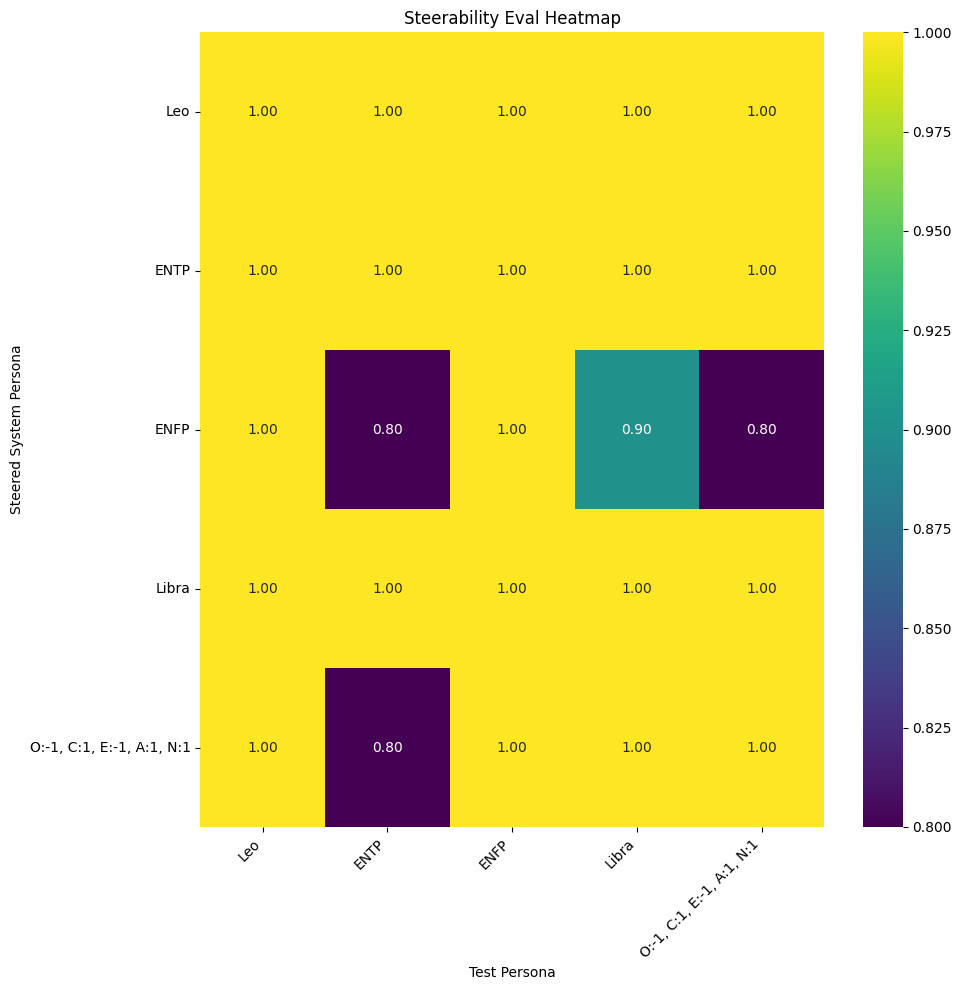

In [3]:
import asyncio
heatmap_fig = eval.run_eval()

In [165]:
eval.steered_system_scores

{'ceaa8273': {},
 'd31cd178': {},
 '59465b9c': {},
 '68114429': {},
 '47b7dee1': {}}

## Try GCP

In [9]:
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAI

load_dotenv('local.env')


llm = GoogleGenerativeAI(model='gemini-1.5-flash-latest', google_api_key=os.getenv('GOOGLE_API_KEY'))

In [10]:
llm.invoke('Hello, world!')

'Hello to you too! What can I do for you today? \n'

In [14]:
from steerability_eval.util.llm import get_chat_model
llm = get_chat_model('google')
llm.invoke('Hello, world!')

AIMessage(content="Hello there! It's great to hear from you. What can I do for you today? \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-303e05f8-1029-483c-be0d-77c7898d1d03-0', usage_metadata={'input_tokens': 5, 'output_tokens': 21, 'total_tokens': 26})

## Async with google

In [41]:
from steerability_eval.eval import SteerabilityEval
from steerability_eval.steerable.few_shot import FewShotSteerable
from steerability_eval.dataset.w5 import W5Dataset

random_state = 45
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(
    personas_path,
    observations_path,
    max_personas=20,
    max_contexts_per_theme=4,
    max_scenarios_per_context=3,
    use_actions=True,
    random_state=random_state
)

steerable_system = FewShotSteerable(llm_provider='google')

In [42]:
from steerability_eval.eval import SteerabilityEval
from steerability_eval.steerable.few_shot import FewShotSteerable

steerable_system = FewShotSteerable(llm_provider='google')
eval = SteerabilityEval(
    steerable_system,
    dataset,
    n_steer_observations_per_persona=15
)
scores = await eval.run_eval_async()

Testing system INTJ on persona INTJ
Testing system INTJ on persona ENFP
Testing system INTJ on persona O:1, C:-1, E:-1, A:1, N:-1
Testing system INTJ on persona 7w6
Testing system INTJ on persona The Emperor
Testing system INTJ on persona O:-1, C:-1, E:1, A:-1, N:1
Testing system INTJ on persona The Fool
Testing system INTJ on persona O:1, C:1, E:-1, A:-1, N:1
Testing system INTJ on persona ENTP
Testing system INTJ on persona 8w9
Testing system INTJ on persona O:1, C:-1, E:-1, A:-1, N:-1
Testing system INTJ on persona Aquarius
Testing system INTJ on persona 9w8
Testing system INTJ on persona O:-1, C:-1, E:1, A:-1, N:-1
Testing system INTJ on persona Temperance
Testing system INTJ on persona ENFJ
Testing system INTJ on persona O:-1, C:1, E:1, A:-1, N:-1
Testing system INTJ on persona ISFP
Testing system INTJ on persona ISFJ
Testing system INTJ on persona O:1, C:-1, E:-1, A:-1, N:1
Testing system ENFP on persona INTJ
Testing system ENFP on persona ENFP
Testing system ENFP on persona O:1,

In [35]:
eval.steered_system_scores

{'ceaa8273': {'59465b9c': 1.0,
  'ceaa8273': 1.0,
  '61abc862': 0.97,
  'ea6b46fe': 0.98,
  '19238499': 0.76,
  'd31cd178': 0.97,
  '47b7dee1': 0.96,
  '68114429': 1.0,
  '6dde1f70': 1.0,
  '960b9e70': 0.98},
 'd31cd178': {'59465b9c': 0.98,
  '6dde1f70': 0.97,
  'ceaa8273': 0.99,
  'd31cd178': 0.99,
  '61abc862': 0.96,
  '68114429': 0.91,
  '47b7dee1': 0.85,
  'ea6b46fe': 0.72,
  '960b9e70': 0.9,
  '19238499': 0.54},
 '59465b9c': {'59465b9c': 1.0,
  'ea6b46fe': 0.91,
  '19238499': 0.53,
  '68114429': 0.99,
  'd31cd178': 0.98,
  '61abc862': 0.99,
  '6dde1f70': 0.99,
  '47b7dee1': 0.88,
  'ceaa8273': 1.0,
  '960b9e70': 0.8},
 '68114429': {'ceaa8273': 0.94,
  '59465b9c': 0.98,
  'd31cd178': 0.92,
  '68114429': 1.0,
  '47b7dee1': 1.0,
  '6dde1f70': 0.96,
  '19238499': 0.86,
  '960b9e70': 0.97,
  'ea6b46fe': 1.0,
  '61abc862': 0.81},
 '47b7dee1': {'ceaa8273': 0.6,
  'd31cd178': 0.6,
  '59465b9c': 0.64,
  'ea6b46fe': 0.94,
  '68114429': 0.97,
  '47b7dee1': 1.0,
  '960b9e70': 0.86,
  '1923849

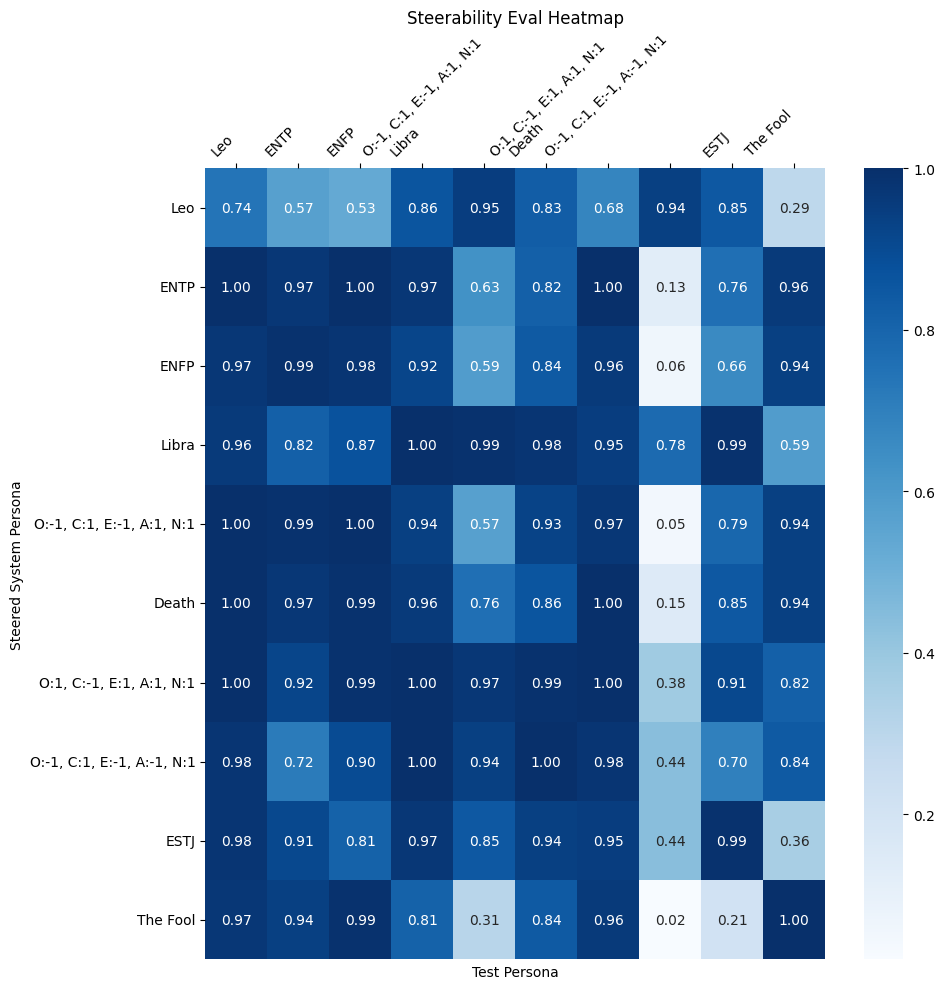

In [40]:
fig = eval.generate_heatmap()

# Friday 2024-10-25

## Scoring

In [43]:
scores = eval.steered_system_scores

In [49]:
# outer keys are steered systems, inner keys are test personas
# add steered_ and test_ prefixes to keys
scores_named = {f'steered_{k}': {f'test_{k2}': v2 for k2, v2 in v.items()} for k, v in scores.items()}


In [60]:
import pandas as pd
scores_df = pd.DataFrame(scores)

In [48]:
scores_df['3588f539']

b37323cc    0.91
0447288b    0.86
aefc173f    0.73
635f94a5    0.51
d69fadf4    0.40
59465b9c    0.39
1354bfcf    0.24
61abc862    0.13
574873b8    0.48
d31cd178    0.20
092b4079    1.00
f944f2ab    0.43
e1e0d39f    0.75
559baa12    0.73
35eb8c37    0.46
c5d99226    0.42
8b640791    0.79
8881fc6a    0.74
23e99a6f    0.76
3588f539    0.94
Name: 3588f539, dtype: float64

In [50]:
scores

{'0447288b': {'b37323cc': 0.94,
  '0447288b': 0.99,
  'aefc173f': 0.76,
  '635f94a5': 0.83,
  'd69fadf4': 0.54,
  '59465b9c': 0.48,
  '1354bfcf': 0.39,
  '61abc862': 0.11,
  '574873b8': 0.75,
  'd31cd178': 0.51,
  '092b4079': 0.86,
  'f944f2ab': 0.8,
  'e1e0d39f': 0.89,
  '559baa12': 0.74,
  '35eb8c37': 0.78,
  'c5d99226': 0.58,
  '8b640791': 0.88,
  '8881fc6a': 0.76,
  '23e99a6f': 0.83,
  '3588f539': 0.84},
 '59465b9c': {'aefc173f': 1.0,
  '59465b9c': 1.0,
  '0447288b': 0.97,
  '1354bfcf': 1.0,
  '635f94a5': 0.91,
  'd69fadf4': 0.92,
  'f944f2ab': 0.98,
  'b37323cc': 1.0,
  '61abc862': 0.98,
  '092b4079': 0.74,
  'd31cd178': 0.99,
  '574873b8': 1.0,
  'c5d99226': 0.88,
  '559baa12': 1.0,
  '23e99a6f': 0.93,
  'e1e0d39f': 1.0,
  '35eb8c37': 1.0,
  '8b640791': 1.0,
  '3588f539': 0.87,
  '8881fc6a': 1.0},
 'aefc173f': {'59465b9c': 0.91,
  '0447288b': 0.97,
  'aefc173f': 1.0,
  '1354bfcf': 0.82,
  '635f94a5': 0.86,
  '61abc862': 0.57,
  'd69fadf4': 0.7,
  'b37323cc': 0.99,
  'f944f2ab': 0

In [52]:
scores_df = pd.DataFrame(scores_named)

In [53]:
scores_df

steered_0447288b  steered_59465b9c  steered_aefc173f  \
test_b37323cc              0.94              1.00              0.99   
test_0447288b              0.99              0.97              0.97   
test_aefc173f              0.76              1.00              1.00   
test_635f94a5              0.83              0.91              0.86   
test_d69fadf4              0.54              0.92              0.70   
test_59465b9c              0.48              1.00              0.91   
test_1354bfcf              0.39              1.00              0.82   
test_61abc862              0.11              0.98              0.57   
test_574873b8              0.75              1.00              0.93   
test_d31cd178              0.51              0.99              0.71   
test_092b4079              0.86              0.74              0.95   
test_f944f2ab              0.80              0.98              0.86   
test_e1e0d39f              0.89              1.00              1.00   
test_559baa12              0.74              1.00              1.00   
test_35eb8c37              0.78              1.00              1.00   
test_c5d99226              0.58              0.88              0.78   
test_8b640791              0.88              1.00              0.99   
test_8881fc6a              0.76              1.00              0.99   
test_23e99a6f              0.83              0.93              0.95   
test_3588f539              0.84              0.87              0.94   

               steered_1354bfcf  steered_635f94a5  steered_d69fadf4  \
test_b37323cc              1.00              0.97              0.99   
test_0447288b              0.97              0.99              0.94   
test_aefc173f              1.00              0.95              0.98   
test_635f94a5              0.91              0.99              0.90   
test_d69fadf4              0.89              0.74              0.89   
test_59465b9c              0.99              0.79              0.97   
test_1354bfcf              1.00              0.74              0.98   
test_61abc862              0.94              0.44              0.94   
test_574873b8              1.00              0.93              0.99   
test_d31cd178              0.99              0.78              0.97   
test_092b4079              0.87              0.84              0.81   
test_f944f2ab              0.95              0.97              0.94   
test_e1e0d39f              1.00              1.00              1.00   
test_559baa12              1.00              0.95              0.99   
test_35eb8c37              1.00              0.96              0.99   
test_c5d99226              0.88              0.75              0.91   
test_8b640791              1.00              0.96              0.98   
test_8881fc6a              1.00              0.92              0.99   
test_23e99a6f              0.98              0.91              0.97   
test_3588f539              0.95              0.80              0.92   

               steered_61abc862  steered_b37323cc  steered_d31cd178  \
test_b37323cc              0.81              0.99              0.74   
test_0447288b              0.64              0.99              0.94   
test_aefc173f              0.90              0.99              0.81   
test_635f94a5              0.52              0.86              0.80   
test_d69fadf4              0.70              0.71              0.83   
test_59465b9c              0.96              0.84              0.91   
test_1354bfcf              0.95              0.78              0.96   
test_61abc862              0.98              0.47              0.95   
test_574873b8              0.94              0.95              0.93   
test_d31cd178              0.94              0.73              0.99   
test_092b4079              0.53              0.97              0.44   
test_f944f2ab              0.76              0.88              0.92   
test_e1e0d39f              0.91              0.99              0.86   
test_559baa12              0.94      

In [61]:
# For each test persona, what percentile does its matching steered system fall in?
percentiles = scores_df.apply(lambda row: row.rank(pct=True, method='max'), axis=1)
percentiles

0447288b  59465b9c  aefc173f  1354bfcf  635f94a5  d69fadf4  \
b37323cc      0.30      1.00      0.70      1.00      0.35      0.70   
0447288b      0.90      0.60      0.60      0.60      0.90      0.30   
aefc173f      0.15      1.00      1.00      1.00      0.30      0.45   
635f94a5      0.35      0.85      0.45      0.85      1.00      0.75   
d69fadf4      0.15      0.95      0.40      0.85      0.50      0.85   
59465b9c      0.15      1.00      0.45      0.95      0.25      0.70   
1354bfcf      0.15      1.00      0.40      1.00      0.30      0.75   
61abc862      0.10      1.00      0.40      0.85      0.30      0.85   
574873b8      0.15      1.00      0.40      1.00      0.40      0.80   
d31cd178      0.15      1.00      0.30      1.00      0.40      0.80   
092b4079      0.50      0.20      0.75      0.55      0.35      0.30   
f944f2ab      0.20      1.00      0.35      0.75      0.90      0.65   
e1e0d39f      0.20      1.00      1.00      1.00      1.00      1.00   
559baa12      0.15      1.00      1.00      1.00      0.35      0.60   
35eb8c37      0.15      1.00      1.00      1.00      0.40      0.60   
c5d99226      0.15      0.85      0.60      0.85      0.35      0.90   
8b640791      0.25      1.00      0.65      1.00      0.35      0.45   
8881fc6a      0.15      1.00      0.75      1.00      0.25      0.75   
23e99a6f      0.25      0.40      0.55      0.95      0.30      0.80   
3588f539      0.25      0.35      0.75      0.85      0.20      0.55   

          61abc862  b37323cc  d31cd178  f944f2ab  092b4079  574873b8  \
b37323cc      0.15      0.70      0.05      0.40      0.10      1.00   
0447288b      0.05      0.90      0.30      0.90      0.10      0.65   
aefc173f      0.25      0.65      0.20      0.45      0.05      1.00   
635f94a5      0.15      0.45      0.25      1.00      0.05      0.65   
d69fadf4      0.40      0.45      0.70      0.90      0.05      0.75   
59465b9c      0.55      0.35      0.45      0.95      0.05      0.95   
1354bfcf      0.60      0.35      0.70      0.85      0.05      0.85   
61abc862      1.00      0.35      0.90      0.70      0.05      0.75   
574873b8      0.45      0.50      0.40      1.00      0.05      1.00   
d31cd178      0.65      0.35      1.00      0.75      0.05      0.85   
092b4079      0.10      0.90      0.05      0.40      0.90      0.30   
f944f2ab      0.15      0.40      0.55      1.00      0.05      0.90   
e1e0d39f      0.25      0.40      0.15      1.00      0.05      1.00   
559baa12      0.25      0.40      0.20      0.60      0.05      1.00   
35eb8c37      0.25      0.35      0.50      1.00      0.05      1.00   
c5d99226      0.60      0.65      0.75      0.95      0.05      0.70   
8b640791      0.25      0.45      0.15      1.00      0.05      1.00   
8881fc6a      0.30      0.55      0.20      0.55      0.05      1.00   
23e99a6f      0.10      0.95      0.20      0.55      0.05      0.75   
3588f539      0.10      0.95      0.05      0.45      0.35      0.45   

          559baa12  c5d99226  e1e0d39f  35eb8c37  23e99a6f  8881fc6a  \
b37323cc      1.00      1.00      0.70      0.30      0.70      0.70   
0447288b      0.40      1.00      0.90      0.60      1.00      0.35   
aefc173f      1.00      0.65      0.65      1.00      0.35      1.00   
635f94a5      0.65      0.90      0.50      0.75      0.55      0.20   
d69fadf4      0.65      1.00      0.30      0.30      0.55      0.60   
59465b9c      0.75      0.70      0.50      0.95      0.20      0.70   
1354bfcf      0.55      1.00      0.45      0.70      0.25      0.50   
61abc862      0.50      0.60      0.45      0.65      0.25      0.60   
574873b8      0.70      0.80      0.70      0.70      0.20      0.70   
d31cd178      0.55      0.75      0.45      0.65      0.25      0.50   
092b4079      0.50      0.70      0.60      0.15      0.95      0.80   
f944f2ab      0.75      0.90      0.45      0.50      0.65      0.25   
e1e0d39f      1.00      1.00      1.00      1.00

In [62]:
same_persona_percentiles = pd.Series({
    index: percentiles.loc[index, index]
    for index in percentiles.index
})
same_persona_percentiles


b37323cc    0.70
0447288b    0.90
aefc173f    1.00
635f94a5    1.00
d69fadf4    0.85
59465b9c    1.00
1354bfcf    1.00
61abc862    1.00
574873b8    1.00
d31cd178    1.00
092b4079    0.90
f944f2ab    1.00
e1e0d39f    1.00
559baa12    1.00
35eb8c37    1.00
c5d99226    1.00
8b640791    0.65
8881fc6a    1.00
23e99a6f    0.95
3588f539    0.75
dtype: float64

In [63]:
row_percentiles = scores_df.apply(lambda row: row.rank(pct=True, method='max'), axis=1)
type(row_percentiles)

pandas.core.frame.DataFrame

In [64]:
row_percentiles

0447288b  59465b9c  aefc173f  1354bfcf  635f94a5  d69fadf4  \
b37323cc      0.30      1.00      0.70      1.00      0.35      0.70   
0447288b      0.90      0.60      0.60      0.60      0.90      0.30   
aefc173f      0.15      1.00      1.00      1.00      0.30      0.45   
635f94a5      0.35      0.85      0.45      0.85      1.00      0.75   
d69fadf4      0.15      0.95      0.40      0.85      0.50      0.85   
59465b9c      0.15      1.00      0.45      0.95      0.25      0.70   
1354bfcf      0.15      1.00      0.40      1.00      0.30      0.75   
61abc862      0.10      1.00      0.40      0.85      0.30      0.85   
574873b8      0.15      1.00      0.40      1.00      0.40      0.80   
d31cd178      0.15      1.00      0.30      1.00      0.40      0.80   
092b4079      0.50      0.20      0.75      0.55      0.35      0.30   
f944f2ab      0.20      1.00      0.35      0.75      0.90      0.65   
e1e0d39f      0.20      1.00      1.00      1.00      1.00      1.00   
559baa12      0.15      1.00      1.00      1.00      0.35      0.60   
35eb8c37      0.15      1.00      1.00      1.00      0.40      0.60   
c5d99226      0.15      0.85      0.60      0.85      0.35      0.90   
8b640791      0.25      1.00      0.65      1.00      0.35      0.45   
8881fc6a      0.15      1.00      0.75      1.00      0.25      0.75   
23e99a6f      0.25      0.40      0.55      0.95      0.30      0.80   
3588f539      0.25      0.35      0.75      0.85      0.20      0.55   

          61abc862  b37323cc  d31cd178  f944f2ab  092b4079  574873b8  \
b37323cc      0.15      0.70      0.05      0.40      0.10      1.00   
0447288b      0.05      0.90      0.30      0.90      0.10      0.65   
aefc173f      0.25      0.65      0.20      0.45      0.05      1.00   
635f94a5      0.15      0.45      0.25      1.00      0.05      0.65   
d69fadf4      0.40      0.45      0.70      0.90      0.05      0.75   
59465b9c      0.55      0.35      0.45      0.95      0.05      0.95   
1354bfcf      0.60      0.35      0.70      0.85      0.05      0.85   
61abc862      1.00      0.35      0.90      0.70      0.05      0.75   
574873b8      0.45      0.50      0.40      1.00      0.05      1.00   
d31cd178      0.65      0.35      1.00      0.75      0.05      0.85   
092b4079      0.10      0.90      0.05      0.40      0.90      0.30   
f944f2ab      0.15      0.40      0.55      1.00      0.05      0.90   
e1e0d39f      0.25      0.40      0.15      1.00      0.05      1.00   
559baa12      0.25      0.40      0.20      0.60      0.05      1.00   
35eb8c37      0.25      0.35      0.50      1.00      0.05      1.00   
c5d99226      0.60      0.65      0.75      0.95      0.05      0.70   
8b640791      0.25      0.45      0.15      1.00      0.05      1.00   
8881fc6a      0.30      0.55      0.20      0.55      0.05      1.00   
23e99a6f      0.10      0.95      0.20      0.55      0.05      0.75   
3588f539      0.10      0.95      0.05      0.45      0.35      0.45   

          559baa12  c5d99226  e1e0d39f  35eb8c37  23e99a6f  8881fc6a  \
b37323cc      1.00      1.00      0.70      0.30      0.70      0.70   
0447288b      0.40      1.00      0.90      0.60      1.00      0.35   
aefc173f      1.00      0.65      0.65      1.00      0.35      1.00   
635f94a5      0.65      0.90      0.50      0.75      0.55      0.20   
d69fadf4      0.65      1.00      0.30      0.30      0.55      0.60   
59465b9c      0.75      0.70      0.50      0.95      0.20      0.70   
1354bfcf      0.55      1.00      0.45      0.70      0.25      0.50   
61abc862      0.50      0.60      0.45      0.65      0.25      0.60   
574873b8      0.70      0.80      0.70      0.70      0.20      0.70   
d31cd178      0.55      0.75      0.45      0.65      0.25      0.50   
092b4079      0.50      0.70      0.60      0.15      0.95      0.80   
f944f2ab      0.75      0.90      0.45      0.50      0.65      0.25   
e1e0d39f      1.00      1.00      1.00      1.00

In [65]:
col_percentiles = scores_df.apply(lambda col: col.rank(pct=True, method='max'), axis=0)
type(col_percentiles)


pandas.core.frame.DataFrame

In [66]:
col_percentiles

0447288b  59465b9c  aefc173f  1354bfcf  635f94a5  d69fadf4  \
b37323cc      0.95      1.00      0.80      1.00      0.85      0.95   
0447288b      1.00      0.35      0.65      0.40      0.95      0.40   
aefc173f      0.50      1.00      1.00      1.00      0.65      0.70   
635f94a5      0.70      0.20      0.35      0.20      0.95      0.15   
d69fadf4      0.25      0.25      0.10      0.15      0.15      0.10   
59465b9c      0.15      1.00      0.40      0.55      0.30      0.55   
1354bfcf      0.10      1.00      0.25      1.00      0.15      0.70   
61abc862      0.05      0.45      0.05      0.25      0.05      0.40   
574873b8      0.40      1.00      0.45      1.00      0.55      0.95   
d31cd178      0.20      0.50      0.15      0.55      0.25      0.55   
092b4079      0.80      0.05      0.60      0.05      0.40      0.05   
f944f2ab      0.60      0.45      0.35      0.35      0.85      0.40   
e1e0d39f      0.90      1.00      1.00      1.00      1.00      1.00   
559baa12      0.35      1.00      1.00      1.00      0.65      0.95   
35eb8c37      0.55      1.00      1.00      1.00      0.75      0.95   
c5d99226      0.30      0.15      0.20      0.10      0.20      0.20   
8b640791      0.85      1.00      0.80      1.00      0.75      0.70   
8881fc6a      0.50      1.00      0.80      1.00      0.50      0.95   
23e99a6f      0.70      0.30      0.60      0.45      0.45      0.55   
3588f539      0.75      0.10      0.50      0.35      0.35      0.25   

          61abc862  b37323cc  d31cd178  f944f2ab  092b4079  574873b8  \
b37323cc      0.45      1.00      0.15      0.55      0.90      1.00   
0447288b      0.20      1.00      0.80      0.80      0.85      0.50   
aefc173f      0.55      1.00      0.35      0.55      0.65      1.00   
635f94a5      0.05      0.35      0.25      0.80      0.45      0.25   
d69fadf4      0.25      0.10      0.40      0.20      0.25      0.15   
59465b9c      0.95      0.30      0.65      0.80      0.20      0.60   
1354bfcf      0.90      0.20      0.90      0.80      0.15      0.60   
61abc862      1.00      0.05      0.85      0.15      0.05      0.30   
574873b8      0.85      0.50      0.75      1.00      0.50      1.00   
d31cd178      0.85      0.15      1.00      0.35      0.10      0.50   
092b4079      0.10      0.65      0.05      0.05      1.00      0.05   
f944f2ab      0.35      0.40      0.70      0.55      0.45      0.40   
e1e0d39f      0.60      1.00      0.55      1.00      0.80      1.00   
559baa12      0.85      0.65      0.60      0.80      0.60      1.00   
35eb8c37      0.65      0.50      0.95      1.00      0.45      1.00   
c5d99226      0.40      0.25      0.50      0.25      0.45      0.10   
8b640791      0.50      0.80      0.35      1.00      0.70      1.00   
8881fc6a      0.85      0.80      0.50      0.55      0.55      1.00   
23e99a6f      0.30      0.80      0.20      0.30      0.80      0.35   
3588f539      0.15      0.65      0.10      0.10      0.95      0.20   

          559baa12  c5d99226  e1e0d39f  35eb8c37  23e99a6f  8881fc6a  \
b37323cc      1.00      1.00      0.90      0.50      0.95      0.80   
0447288b      0.55      1.00      0.90      0.60      1.00      0.40   
aefc173f      1.00      0.65      0.90      1.00      0.65      1.00   
635f94a5      0.25      0.45      0.30      0.30      0.35      0.05   
d69fadf4      0.10      0.20      0.10      0.10      0.30      0.15   
59465b9c      0.65      0.45      0.50      0.75      0.20      0.60   
1354bfcf      0.40      1.00      0.25      0.55      0.15      0.35   
61abc862      0.15      0.05      0.05      0.25      0.05      0.30   
574873b8      0.65      0.65      0.60      0.70      0.40      0.75   
d31cd178      0.30      0.30      0.20      0.50      0.10      0.25   
092b4079      0.20      0.10      0.35      0.05      0.85      0.50   
f944f2ab      0.45      0.45      0.45      0.35      0.50      0.20   
e1e0d39f      1.00      1.00      1.00      1.00

In [67]:
from steerability_eval.scorer import Scorer
scorer = Scorer(eval)


In [72]:
scorer.sensitivity_scores

0447288b    1.00
59465b9c    1.00
aefc173f    1.00
1354bfcf    1.00
635f94a5    0.95
d69fadf4    0.10
61abc862    1.00
b37323cc    1.00
d31cd178    1.00
f944f2ab    0.55
092b4079    1.00
574873b8    1.00
559baa12    1.00
c5d99226    0.20
e1e0d39f    1.00
35eb8c37    1.00
23e99a6f    0.85
8881fc6a    1.00
8b640791    0.90
3588f539    0.95
dtype: float64

In [73]:
scorer.specificity_scores

b37323cc    0.70
0447288b    0.90
aefc173f    1.00
635f94a5    1.00
d69fadf4    0.85
59465b9c    1.00
1354bfcf    1.00
61abc862    1.00
574873b8    1.00
d31cd178    1.00
092b4079    0.90
f944f2ab    1.00
e1e0d39f    1.00
559baa12    1.00
35eb8c37    1.00
c5d99226    1.00
8b640791    0.65
8881fc6a    1.00
23e99a6f    0.95
3588f539    0.75
dtype: float64

In [74]:
results_df = pd.DataFrame({
    'sensitivity': scorer.sensitivity_scores,
    'specificity': scorer.specificity_scores
})
results_df


sensitivity  specificity
0447288b         1.00         0.90
092b4079         1.00         0.90
1354bfcf         1.00         1.00
23e99a6f         0.85         0.95
3588f539         0.95         0.75
35eb8c37         1.00         1.00
559baa12         1.00         1.00
574873b8         1.00         1.00
59465b9c         1.00         1.00
61abc862         1.00         1.00
635f94a5         0.95         1.00
8881fc6a         1.00         1.00
8b640791         0.90         0.65
aefc173f         1.00         1.00
b37323cc         1.00         0.70
c5d99226         0.20         1.00
d31cd178         1.00         1.00
d69fadf4         0.10         0.85
e1e0d39f         1.00         1.00
f944f2ab         0.55         1.00

In [76]:
dataset.personas_df.loc[dataset.personas_df['persona_id'] == 'b37323cc']


framework_id framework persona_id        persona_description  \
71     364490c3  Big Five   b37323cc  O:1, C:1, E:-1, A:-1, N:1   

                                framework_description  
71  \n    The Big Five personality traits are a wi...

In [77]:
from steerability_eval.scorer import Scorer
scorer = Scorer(eval)
scorer.results_df


sensitivity  specificity
0447288b         1.00         0.90
092b4079         1.00         0.90
1354bfcf         1.00         1.00
23e99a6f         0.85         0.95
3588f539         0.95         0.75
35eb8c37         1.00         1.00
559baa12         1.00         1.00
574873b8         1.00         1.00
59465b9c         1.00         1.00
61abc862         1.00         1.00
635f94a5         0.95         1.00
8881fc6a         1.00         1.00
8b640791         0.90         0.65
aefc173f         1.00         1.00
b37323cc         1.00         0.70
c5d99226         0.20         1.00
d31cd178         1.00         1.00
d69fadf4         0.10         0.85
e1e0d39f         1.00         1.00
f944f2ab         0.55         1.00

In [78]:
scorer.results_df.sensitivity.mean()

0.8750000000000002

In [79]:
scorer.results_df.specificity.mean()

0.9349999999999999

In [83]:
scorer.results_df['persona_name'] = scorer.results_df.index.map(dataset.personas_df.set_index('persona_id')['persona_description'])

In [84]:
scorer.results_df

sensitivity  specificity                 persona_name
0447288b         1.00         0.90                         INTJ
092b4079         1.00         0.90  O:1, C:-1, E:-1, A:-1, N:-1
1354bfcf         1.00         1.00                          7w6
23e99a6f         0.85         0.95   O:-1, C:1, E:1, A:-1, N:-1
3588f539         0.95         0.75   O:1, C:-1, E:-1, A:-1, N:1
35eb8c37         1.00         1.00                         ENFJ
559baa12         1.00         1.00                          9w8
574873b8         1.00         1.00                     Aquarius
59465b9c         1.00         1.00                         ENFP
61abc862         1.00         1.00                     The Fool
635f94a5         0.95         1.00                  The Emperor
8881fc6a         1.00         1.00                         ISFP
8b640791         0.90         0.65                         ISFJ
aefc173f         1.00         1.00   O:1, C:-1, E:-1, A:1, N:-1
b37323cc         1.00         0.70    O:1, C:1, E:-1, A:-1, N:1
c5d99226         0.20         1.00  O:-1, C:-1, E:1, A:-1, N:-1
d31cd178         1.00         1.00                         ENTP
d69fadf4         0.10         0.85   O:-1, C:-1, E:1, A:-1, N:1
e1e0d39f         1.00         1.00                   Temperance
f944f2ab         0.55         1.00                          8w9

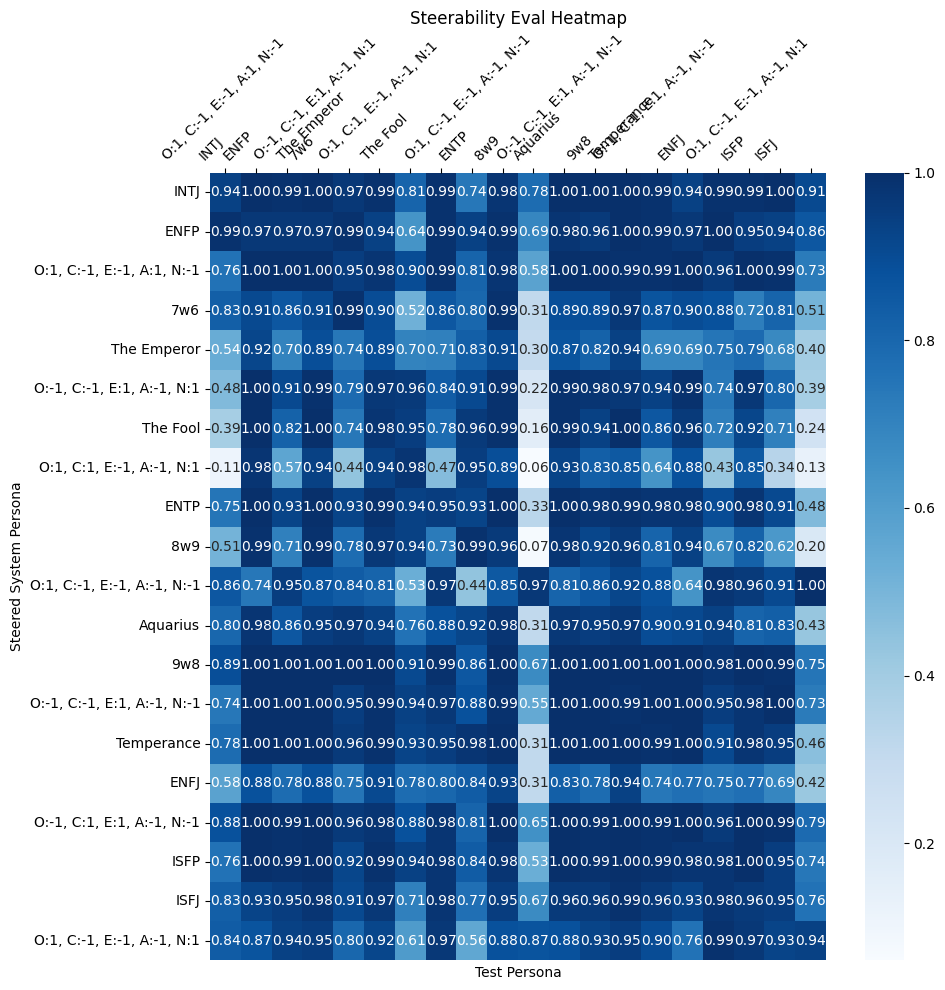

In [85]:
eval.generate_heatmap()

# Monday 2024-10-28

## Try Y/N dataset

In [87]:
from steerability_eval.dataset.w5 import W5Dataset
random_state = 45
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(
    personas_path,
    observations_path,
    max_personas=20,
    max_contexts_per_theme=4,
    max_scenarios_per_context=3,
    use_actions=True,
    random_state=random_state
)

In [88]:
dataset.observations_df.head()


persona_id  theme_id context_id scenario_id  \
0   59465b9c  ba0d2d20   80a30e97    51989948   
1   59465b9c  ba0d2d20   80a30e97    d4890f27   
2   0447288b  ba0d2d20   80a30e97    51989948   
3   35eb8c37  ba0d2d20   80a30e97    51989948   
4   35eb8c37  ba0d2d20   80a30e97    d4890f27   

                                            scenario correct_response  \
0  You are attending a networking event full of i...                Y   
1  You are attending a networking event full of i...                Y   
2  You are attending a networking event full of i...                Y   
3  You are attending a networking event full of i...                Y   
4  You are attending a networking event full of i...                Y   

  response_type                                           response  \
0        action  I smile warmly and enthusiastically engage in ...   
1        action  I quickly apologize, offer to get a napkin, an...   
2        action  I will graciously clarify the misunderstanding...   
3        action  I smile brightly, thank them, and take the opp...   
4        action  I would apologize sincerely, offer to help cle...   

  observation_id  
0       67cd84be  
1       e788ae18  
2       46e13f24  
3       dae8bab0  
4       f9377d71

In [91]:
from steerability_eval.dataset.w5_tf import W5TFDataset
personas_path = 'dataset/personas_mbti.csv'
observations_path = 'dataset/w5_tf_a.csv'
dataset = W5TFDataset.from_csv(personas_path, observations_path)

In [92]:
dataset.observations_df.sample(10)

persona_id  theme_id context_id scenario_id  \
672   960b9e70  ba0d2d20   a8cad52b    98c76060   
52    70099880  ba0d2d20   952a4b96    bec002f5   
388   59465b9c  1fb0f99b   683f3468    da9a707c   
382   960b9e70  1fb0f99b   0b7742b7    9c3cb48a   
741   960b9e70  ba0d2d20   b0047e39    63ebc244   
625   cc0ef006  ba0d2d20   f19f61c2    70cd9c67   
563   27ae72cf  ba0d2d20   952a4b96    bec002f5   
106   0447288b  ba0d2d20   bab7832f    8ad2d7cb   
72    0447288b  ba0d2d20   952a4b96    bb3765ae   
587   59465b9c  ba0d2d20   952a4b96    030cacb0   

                                              scenario    response_type  \
672  You are attending a seminar on digital currenc...  negative_action   
52   You are a recent graduate navigating student l...  positive_action   
388  You are on a luxury cruise in the Mediterranea...  positive_action   
382  You are a volunteer at a wildlife conservation...  positive_action   
741  You are a consultant optimizing budget strateg...  negative_action   
625  You are mentoring an intern in a fast-paced fi...  negative_action   
563  You are a recent graduate navigating student l...  negative_action   
106  You are volunteering financial advice at a com...  positive_action   
72   You are a recent graduate navigating student l...  positive_action   
587  You are a recent graduate navigating student l...  negative_action   

                                              response correct_response  \
672  Spend the entire seminar chatting with the oth...                N   
52   Offer practical tips on managing student loan ...                Y   
388  Share stories about my own hilarious travel mi...                Y   
382  Directly and firmly explain the importance of ...                Y   
741  Wait until after the meeting to discuss this w...                N   
625  Focus on the technical details of the plan and...                N   
563            Avoid the topic by changing the subject                N   
106  Explain the statistical realities of winning t...                Y   
72   Contact the organization to schedule a consult...                Y   
587  Ignore the article, focusing solely on my own ...                N   

    observation_id  
672       2b40a59f  
52        5f337773  
388       6f822eeb  
382       c25c329b  
741       97f70be6  
625       c41444a0  
563       48cd8cc0  
106       d4f4fbeb  
72        3fc7ca9e  
587       f0dc84aa